# Test against HMcode

In [1]:
import numpy as np

%matplotlib inline
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as spline

%load_ext autoreload
%autoreload 2

## Run HMcode

First, we run HMCode. We use `ihm=2`, which is the simple halo model calculation (needs to be set in-code and recompiled). The precise version (git hash) we use is `a53bb0ea574bc19d45467e6847cb0753eca49e93` (Nov 6 2019). 

Line numbers / function names used throughout refer to this version.

In [2]:
hmcode_dir = Path("/home/steven/Documents/Projects/halos/HALOMOD/other-codes/HMcode")

In [3]:
def read_power(fname):
    # Each column is the power at a different redshift.
    with open(fname) as fl:
        line = fl.readline().split("#####")[-1].split("        ")[1:]
        redshifts = [float(x) for x in line]

    data = np.genfromtxt(fname, skip_header=1)
    k = data[:, 0]
    return k, redshifts, data[:, 1:]

In [4]:
k, redshifts, data = read_power(hmcode_dir / "power.dat")

## Make halomod model

In [5]:
from halomod import DMHaloModel

In [6]:
hm = DMHaloModel(
    exclusion_model=None,
    sd_bias_model=None,
    transfer_model="EH_BAO",
    cosmo_params={
        "Tcmb0": 2.725,  # Line 596
        "Om0": 0.3,  # Line 587
        "Ob0": 0.05,  # Line 589
        "H0": 70.0,  # Line 591
    },
    hc_spectrum="linear",
    halo_concentration_model="Bullock01",
    halo_concentration_params={"K": 4, "F": 0.01},  # Line 376
    hmf_model="SMT",
    sigma_8=0.8,  # Line 593
    n=0.96,  # Line 594
    Mmin=2,  # Line 795
    Mmax=18,  # Line 796,
    lnk_min=np.log(1e-3),  # Line 50
    lnk_max=np.log(1e2),  # Line 51
    dlnk=np.log(1e2 / 1e-3) / 129,  # Line 52
    dlog10m=16 / 256,
    mdef_model="SOMean",
    disable_mass_conversion=True,
)

### The big picture (1h+2h)

/home/steven/Documents/Projects/halos/HALOMOD/halomod/src/halomod/concentration.py:123: UserWarning: Requested mass definition 'SOMean(200)' is not in native definitions for the 'Bullock01' CMRelation. No mass conversion will be performed, so results will be wrong. Using 'SOMean(200)'.
  f"Requested mass definition '{mdef}' is not in native definitions for "


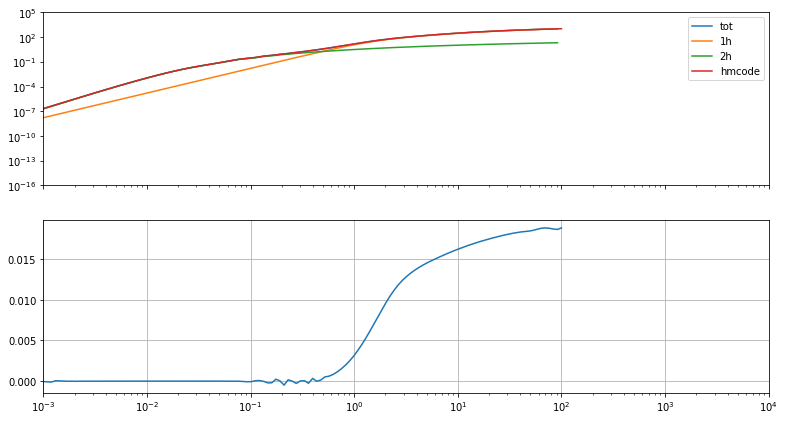

In [7]:
fig, ax = plt.subplots(
    2, 1, sharex=True, subplot_kw={"xscale": "log", "xlim": (1e-3, 1e4)}, figsize=(13, 7)
)
ax[0].plot(hm.k, hm.power_auto_matter * hm.k**3 / (2 * np.pi**2), label="tot")
ax[0].plot(hm.k, hm.power_1h_auto_matter * hm.k**3 / (2 * np.pi**2), label="1h")
ax[0].plot(hm.k, hm.power_2h_auto_matter * hm.k**3 / (2 * np.pi**2), label="2h")
ax[0].plot(k, data[:, 0], label="hmcode")
ax[0].set_yscale("log")

ax[0].set_ylim((1e-16, 1e5))
ax[0].legend(loc=0)

spl = spline(np.log(hm.k), np.log(hm.power_auto_matter * hm.k**3 / (2 * np.pi**2)))
ax[1].plot(k, np.exp(spl(np.log(k))) / data[:, 0] - 1)
ax[1].grid(True)

## Intermediate Products

Since we are using the forked version of HMCode which prints out intermediate results, we can compare.

In [8]:
hmc_intermediate = np.genfromtxt(
    "/home/steven/Documents/Projects/halos/HALOMOD/other-codes/HMcode/mass_data.dat"
)

In [9]:
m = hmc_intermediate[0]

In [10]:
def get(thing, iz=0):
    things = ["rv", "nu", "rr", "sig", "sigf", "zc", "c", "gnu"]
    indx = iz * len(things) + 1 + things.index(thing)
    return hmc_intermediate[indx]

### Mass to Radius

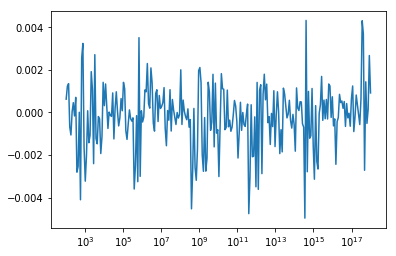

In [11]:
# Redshift 0
r = spline(hm.m, hm.radii)(m)
plt.plot(m, r / get("rr") - 1)
plt.xscale("log")

### sigma

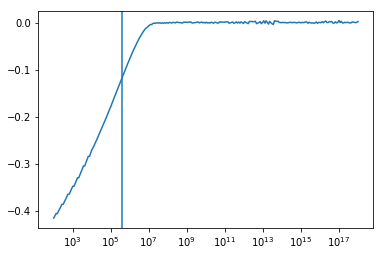

In [12]:
sig = spline(hm.m, hm.sigma)(m)
plt.plot(m, sig / get("sig") - 1)
# There's an "rsplit" parameter of 1e-2 in HMcode where the integral is treated differently
# Maybe it corresponds to the break?
plt.axvline(m[np.where(r > 1e-2)[0][0]])
plt.xscale("log")

We see that $\sigma$ is quite different at low masses. HMCode uses a "rapidising" function (Line 1839) to make the integral faster -- potentially that is causing problems at low mass. On the other hand, maybe hmf is doing the wrong thing?

If we update the k-bounds for hmf (the thing we're integrating over here), let's see what happens:

In [13]:
hm.update(lnk_max=np.log(1e5))

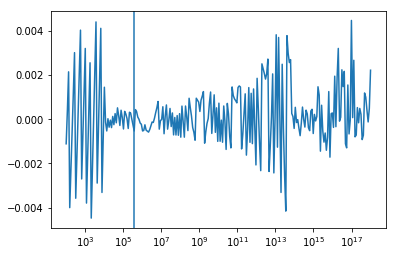

In [14]:
sig = spline(hm.m, hm.sigma)(m)
plt.plot(m, sig / get("sig") - 1)
# There's an "rsplit" parameter of 1e-2 in HMcode where the integral is treated differently
# Maybe it corresponds to the break?
plt.axvline(m[np.where(r > 1e-2)[0][0]])
plt.xscale("log")

This fixes the issue. So even though HMCode seems to be able to get away with using a smaller k-range, hmf cannot.

### nu

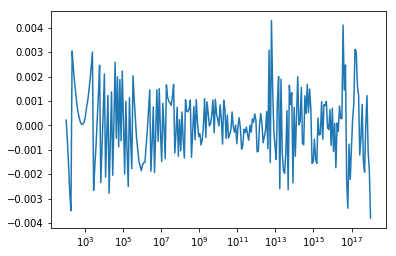

In [15]:
nu = np.sqrt(spline(hm.m, hm.nu)(m))
plt.plot(m, nu / get("nu") - 1)
plt.xscale("log")

### Growth Function

In [16]:
hmc_growth = np.genfromtxt(
    "/home/steven/Documents/Projects/halos/HALOMOD/other-codes/HMcode/growth_data.dat"
)

In [17]:
zz = 1 / hmc_growth[:, 0] - 1

In [18]:
hm_growth_fn = hm.growth.growth_factor_fn()

In [19]:
hm.update(growth_params={"dlna": 0.01, "amin": 1e-12})

In [20]:
from scipy.integrate import quad

In [21]:
intg = lambda z: (1 + z) / hm.cosmo.H(z).value ** 3

In [22]:
g0 = quad(intg, 0, np.inf)[0]

In [23]:
growths = []
for i, z in enumerate(zz):
    growths.append(quad(intg, z, np.inf)[0] * hm.cosmo.H(z).value / (g0 * hm.cosmo.H(0).value))

In [24]:
hm_growths = np.array([hm.growth.growth_factor(z) for z in zz])

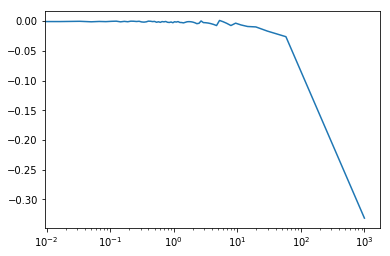

In [25]:
plt.plot(zz, hm_growths / hmc_growth[:, 1] - 1)
# plt.plot(zz, [hm.growth.growth_factor(z) for z in zz])
# plt.plot(zz, growths)
plt.xscale("log")
# plt.yscale('log')

Though there is some discrepancy for large redshifts (>100), the discrepancy seems to be in favour of `hmf` (when compared to pure quadrature integration) and anyway, discrepancy is well under 5% for redshifts actually used (as collapse redshift).

(-0.02, 0.02)

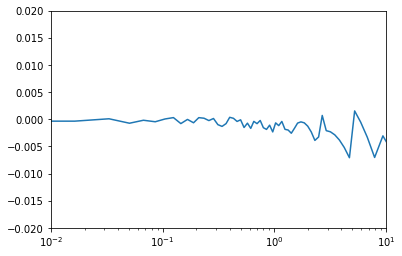

In [26]:
plt.plot(zz, hm_growths / hmc_growth[:, 1] - 1)
# plt.plot(zz, [hm.growth.growth_factor(z) for z in zz])
# plt.plot(zz, growths)
plt.xscale("log")
plt.xlim(1e-2, 10)
plt.ylim(-0.02, 0.02)
# plt.yscale('log')

### Sig-f

In [27]:
nuf = 1.686 / get("sigf")
r = hm.halo_concentration.filter.mass_to_radius(
    hm.halo_concentration.params["F"] * m, hm.halo_concentration.mean_density0
)
hm_nu = hm.halo_concentration.filter.nu(r, 1.686)

hm_nu = np.sqrt(spline(hm.m, hm_nu)(m))

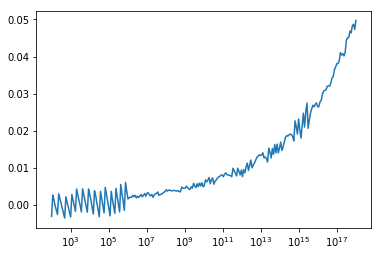

In [28]:
plt.plot(m, hm_nu / nuf - 1)
plt.xscale("log")

### Collapse Redshift

Maximum collapse redshift:  10.383500695324066


/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.01, 0.01)

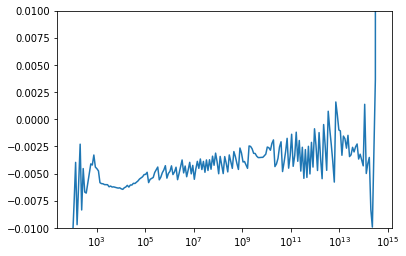

In [29]:
zc = spline(hm.m, hm.halo_concentration.zc(hm.m))(m)
print("Maximum collapse redshift: ", zc.max())
plt.plot(m, zc / get("zc") - 1)
plt.xscale("log")
plt.ylim(-0.01, 0.01)

### Concentration

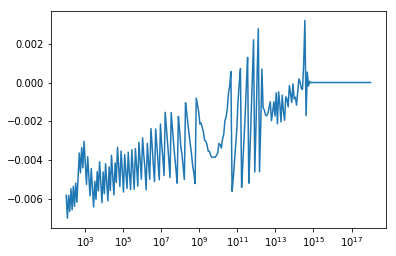

In [30]:
c = spline(hm.m, hm.cmz_relation)(m)
plt.plot(m, c / get("c") - 1)
plt.xscale("log")

### 2-halo

The 2-halo term in HMcode, with imead=0, is just the linear power, which means we should get it exactly if our transfer function is correct, and normalisation as well.

In [14]:
k, _, data_lin = read_power(hmcode_dir / "power_linear.dat")

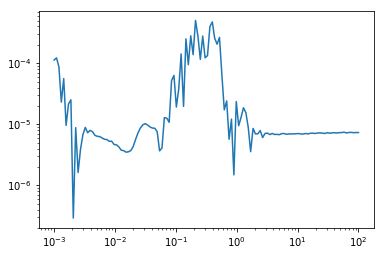

In [32]:
spl = spline(hm.k, hm.delta_k)
plt.plot(k, np.abs(spl(k) / data_lin[:, 0] - 1))

plt.xscale("log")
plt.yscale("log")

I think we can be pretty confident that our linear power spectrum is lining up, to within 0.06%

In [15]:
k, _, data_2h = read_power(hmcode_dir / "power_2halo.dat")

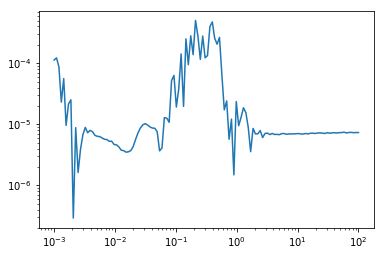

In [34]:
spl = spline(hm.k, hm.power_2h_auto_matter * hm.k**3 / (2 * np.pi**2))
plt.plot(k, np.abs(spl(k) / data_2h[:, 0] - 1))
plt.xscale("log")
plt.yscale("log")

As we would hope, this is precisely the same plot as for the linear power. There are some weird things around the scale of the BAO peak, which may even come from our spline interpolation, but things are pretty close overall.

### Mass Function

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(-0.01, 0.01)

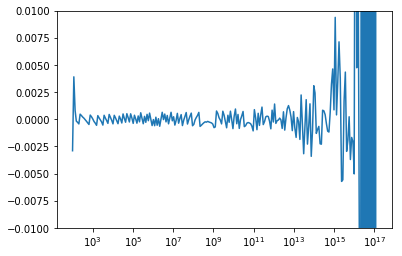

In [35]:
gnu = spline(hm.m, hm.fsigma / np.sqrt(hm.nu))(m)
plt.plot(m, gnu / get("gnu") - 1)
plt.xscale("log")
plt.ylim(-0.01, 0.01)

### Virial Radius

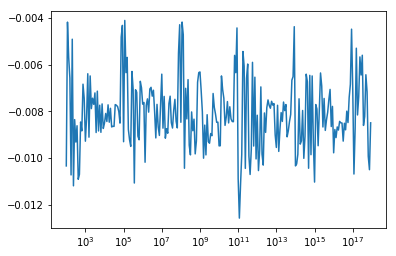

In [36]:
plt.plot(hm.m, hm.halo_profile._halo_mass_to_radius(m) / get("rv") - 1)
plt.xscale("log")

### Halo Profile (u)

In [33]:
ukm = np.genfromtxt(hmcode_dir / "ukm.dat")
with open(hmcode_dir / "1h_integrand.dat") as fl:
    kk = float(fl.readline().split("=")[-1].strip())

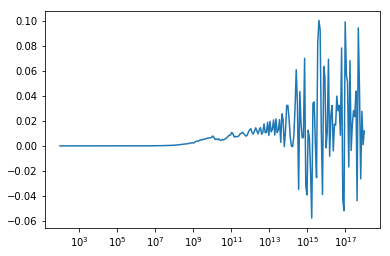

In [35]:
hm_ukm = hm.halo_profile.u(kk, m)
plt.plot(m, hm_ukm / ukm[0] - 1)
plt.xscale("log")

### 1-halo

In [16]:
k, _, data_1h = read_power(hmcode_dir / "power_1halo.dat")

Now, the way that HMCode is written is a bit confusing on the face of it, but that's because it integrates over $\nu$ instead of $m$ directly. It turns out this is actually a little easier than integrating over $m$. Here's the math for posterity:

An integral of any function over mass with a factor of the mass function can be written:

\begin{equation}
    I = \int \frac{dn}{dm} g(m) dm.
\end{equation}

Now,

\begin{align}
    \frac{dn}{dm} &= - \frac{\bar{\rho}}{m^2} \nu f(\nu) \frac{d\ln\sigma}{d\ln m} \\
    &= - \frac{\bar{\rho}}{m \sigma} \nu f(\nu) \frac{d\sigma}{d m} \\
    &= - \frac{\bar{\rho}}{m \delta_c} \nu^2 f(\nu) \frac{d \sigma}{d\nu} \frac{d \nu}{dm}
    &= \frac{\bar{\rho}}{m} f(\nu) \frac{d \nu}{dm}
\end{align}

So we have

\begin{equation}
    I = \int \frac{\bar{\rho}}{m} f(\nu) g(m) d\nu.
\end{equation}

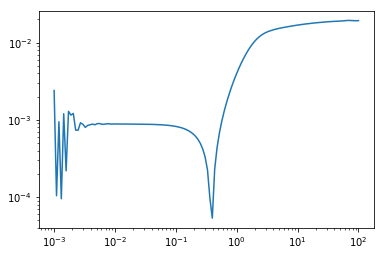

In [37]:
spl = spline(hm.k, hm.power_1h_auto_matter * hm.k**3 / (2 * np.pi**2))
plt.plot(k, np.abs(spl(k) / data_1h[:, 0] - 1))

plt.xscale("log")
plt.yscale("log")

There is a 60% difference at small scales here... !!??

### Full Picture (with increased k range)

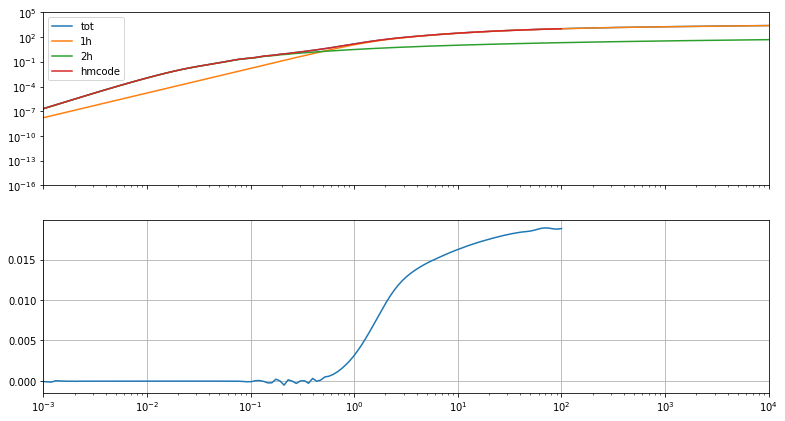

In [42]:
fig, ax = plt.subplots(
    2, 1, sharex=True, subplot_kw={"xscale": "log", "xlim": (1e-3, 1e4)}, figsize=(13, 7)
)
ax[0].plot(hm.k, hm.power_auto_matter * hm.k**3 / (2 * np.pi**2), label="tot")
ax[0].plot(hm.k, hm.power_1h_auto_matter * hm.k**3 / (2 * np.pi**2), label="1h")
ax[0].plot(hm.k, hm.power_2h_auto_matter * hm.k**3 / (2 * np.pi**2), label="2h")
ax[0].plot(k, data[:, 0], label="hmcode")
ax[0].set_yscale("log")

ax[0].set_ylim((1e-16, 1e5))
ax[0].legend(loc=0)

spl = spline(np.log(hm.k), np.log(hm.power_auto_matter * hm.k**3 / (2 * np.pi**2)))
ax[1].plot(k, np.exp(spl(np.log(k))) / data[:, 0] - 1)
ax[1].grid(True)

## High Redshift

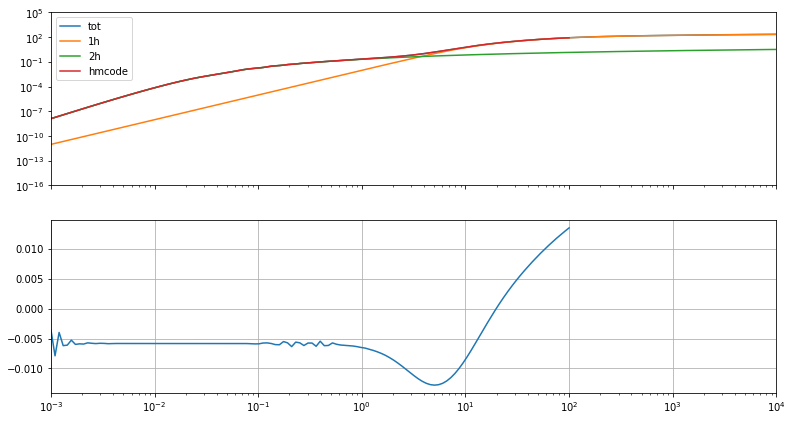

In [38]:
hm.update(z=4)

fig, ax = plt.subplots(
    2, 1, sharex=True, subplot_kw={"xscale": "log", "xlim": (1e-3, 1e4)}, figsize=(13, 7)
)
ax[0].plot(hm.k, hm.power_auto_matter * hm.k**3 / (2 * np.pi**2), label="tot")
ax[0].plot(hm.k, hm.power_1h_auto_matter * hm.k**3 / (2 * np.pi**2), label="1h")
ax[0].plot(hm.k, hm.power_2h_auto_matter * hm.k**3 / (2 * np.pi**2), label="2h")

ax[0].plot(k, data[:, -1], label="hmcode")
ax[0].set_yscale("log")

ax[0].set_ylim((1e-16, 1e5))
ax[0].legend(loc=0)

spl = spline(np.log(hm.k), np.log(hm.power_auto_matter * hm.k**3 / (2 * np.pi**2)))
ax[1].plot(k, np.exp(spl(np.log(k))) / data[:, -1] - 1)
ax[1].grid(True)

Seems to be just the 1-halo term which hasn't evolved properly. Let's look at the bits again.

### Radii

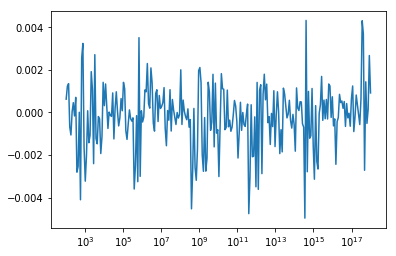

In [44]:
r = spline(hm.m, hm.radii)(m)
plt.plot(m, r / get("rr", iz=15) - 1)
plt.xscale("log")

### Sigma

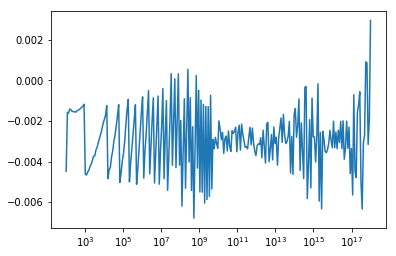

In [45]:
sig = spline(hm.m, hm.sigma)(m)
plt.plot(m, sig / get("sig", iz=15) - 1)
plt.xscale("log")

This is obviously off by a fraction of a percent... not sure if that's worth worrying about.

### nu

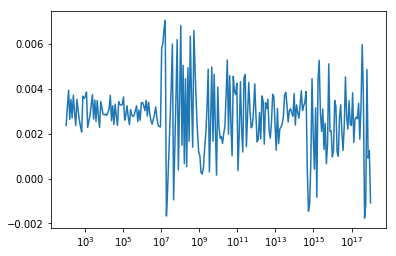

In [46]:
nu = np.sqrt(spline(hm.m, hm.nu)(m))
plt.plot(m, nu / get("nu", iz=15) - 1)
plt.xscale("log")

### Sig-f

In [19]:
nuf = 1.686 / get("sigf", iz=15)
r = hm.halo_concentration.filter.mass_to_radius(
    hm.halo_concentration.params["F"] * m, hm.halo_concentration.mean_density0
)
hm_nu = hm.halo_concentration.filter.nu(r, 1.686) / hm.growth_factor**2

hm_nu = np.sqrt(spline(hm.m, hm_nu)(m))

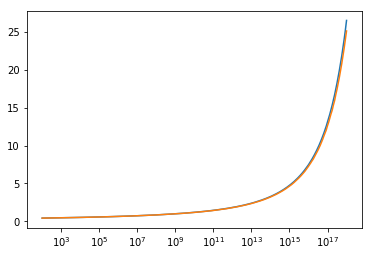

In [20]:
plt.plot(m, hm_nu)
plt.plot(m, nuf)
plt.xscale("log")

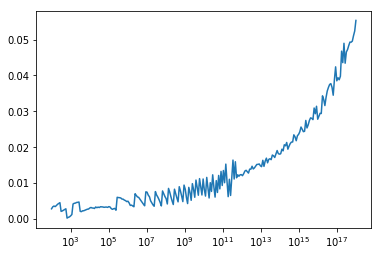

In [21]:
plt.plot(m, hm_nu / nuf - 1)
plt.xscale("log")

### Collapse Redshift

Maximum collapse redshift:  10.38350076866714


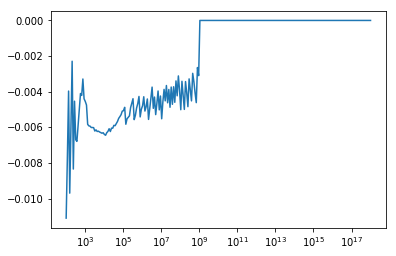

In [22]:
zc = hm.halo_concentration.zc(m, z=4)
print("Maximum collapse redshift: ", zc.max())
plt.plot(m, zc / get("zc", iz=15) - 1)
plt.xscale("log")
# plt.ylim(-0.05,0.05)

### Concentration

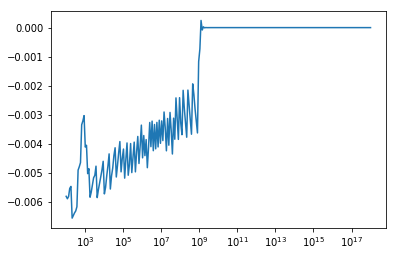

In [23]:
c = spline(hm.m, hm.cmz_relation)(m)
plt.plot(m, c / get("c", iz=15) - 1)
plt.xscale("log")

### 2-halo

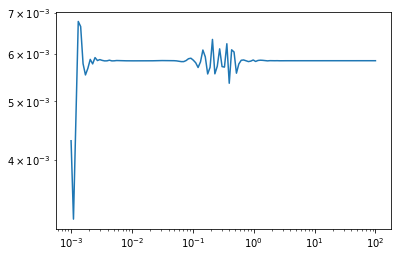

In [30]:
spl = spline(hm.k, hm.power_2h_auto_matter * hm.k**3 / (2 * np.pi**2))
plt.plot(k, np.abs(spl(k) / data_2h[:, -1] - 1))
plt.xscale("log")
plt.yscale("log")

### Mass Function

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(-0.05, 0.05)

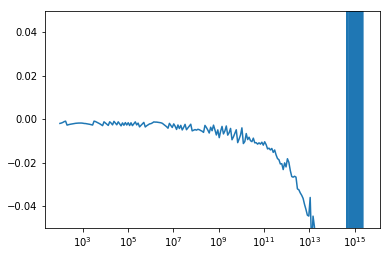

In [32]:
gnu = spline(hm.m, hm.fsigma / np.sqrt(hm.nu))(m)
plt.plot(m, gnu / get("gnu", iz=15) - 1)
plt.xscale("log")
plt.ylim(-0.05, 0.05)

The difference here seems to be due to slight differences in $\nu$ (of 0.5%) which get blown up in the exponential of the mass function:

\begin{equation}
 \exp(-q \nu^2 / 2)/\exp(-q \nu^2 (1 + \delta)^2 / 2) \approx \exp(-q \nu^2 / 2 ( 1 - (1 + \delta)^2)) \approx \exp(-q \nu^2 \delta ).
\end{equation}

With $\delta \approx 0.005$ and $q = 0.707$, $\nu$ does not need to be very large before differences of a few percent will arise.

On the other hand, at these higher redshifts, we don't expect these larger masses to contribute very significantly to the 1-halo integral.

### Virial Radius

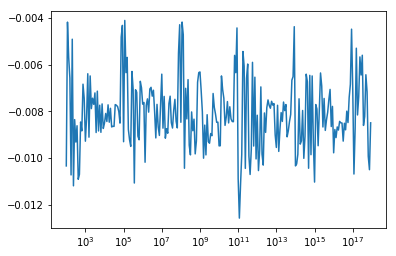

In [39]:
plt.plot(hm.m, hm.halo_profile._halo_mass_to_radius(m) / get("rv", iz=15) - 1)
plt.xscale("log")

### Ukm

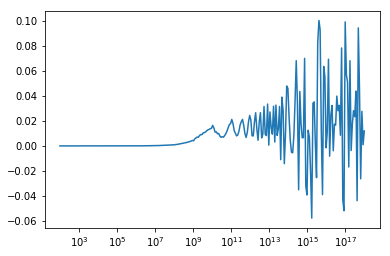

In [40]:
hm_ukm = hm.halo_profile.u(kk, m)
plt.plot(m, hm_ukm / ukm[-1] - 1)
plt.xscale("log")

### 1-halo

/home/steven/miniconda3/envs/halomod/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


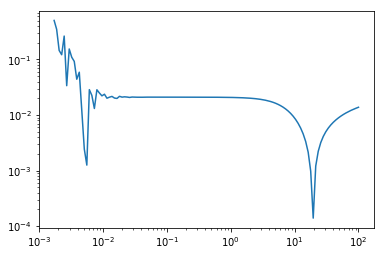

In [41]:
spl = spline(hm.k, hm.power_1h_auto_matter * hm.k**3 / (2 * np.pi**2))
plt.plot(k, np.abs(spl(k) / data_1h[:, -1] - 1))

plt.xscale("log")
plt.yscale("log")